In [5]:

pip install pandas numpy matplotlib seaborn beautifulsoup4 textblob spacy scikit-learn nltk


   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 626.3/626.3 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.2 MB 5.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/12.2 MB 4.6 MB/s eta 0:00:03
   -------- ------------------------------- 2.6/12.2 MB 4.2 MB/s eta 0:00:03
   ----------- ---------------------------- 3.4/12.2 MB 4.1 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.2 MB 3.8 MB/s eta 0:00:03
   ---------------- ----------------------- 5.0/12.2 MB 3.9 MB/s eta 0:00:02
   ------------------- -------------------- 6.0/12.2 MB 3.9 MB/s eta 0:00:02
   ---------------------- ----------------- 6.8/12.2 MB 3.9 MB/s eta 0:00:02
   ------------------------ --------------- 7.3/12.2 MB 3.9 MB/s eta 0:00:02
   --------------------------- ------------ 8.4/12.2 MB 3.9 MB/s eta 0:00:01
   ------

In [10]:
import spacy
nlp = spacy.load("en_core_web_sm")
print("SpaCy model loaded successfully!")


SpaCy model loaded successfully!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vineet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vineet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


        id                                              title  \
0   8476.0                       You Can Smell Hillary’s Fear   
1  10294.0  Watch The Exact Moment Paul Ryan Committed Pol...   
2   3608.0        Kerry to go to Paris in gesture of sympathy   
3  10142.0  Bernie supporters on Twitter erupt in anger ag...   
4    875.0   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7818 entries, 0 to 7817
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      257 non-null    float64
 1   title   257 non-null 

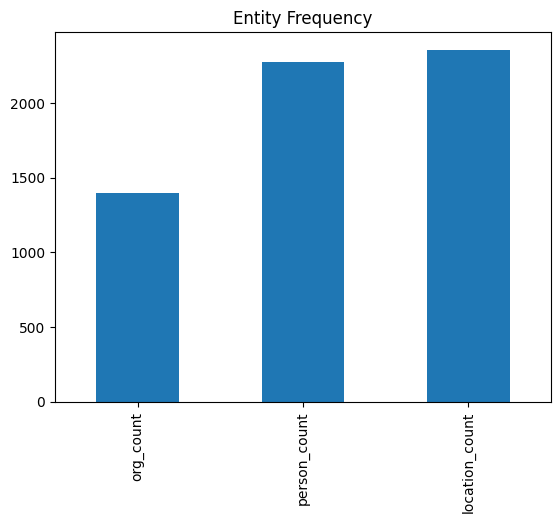

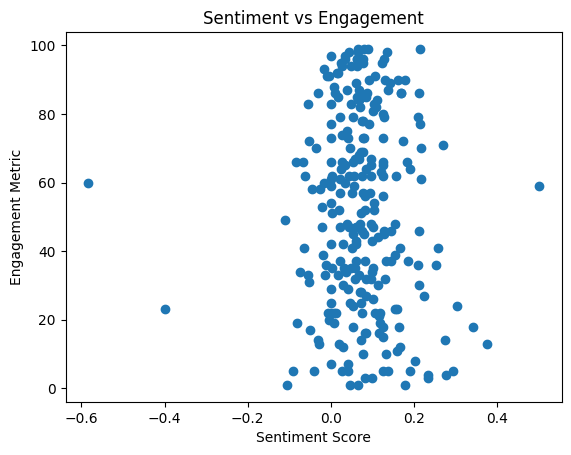

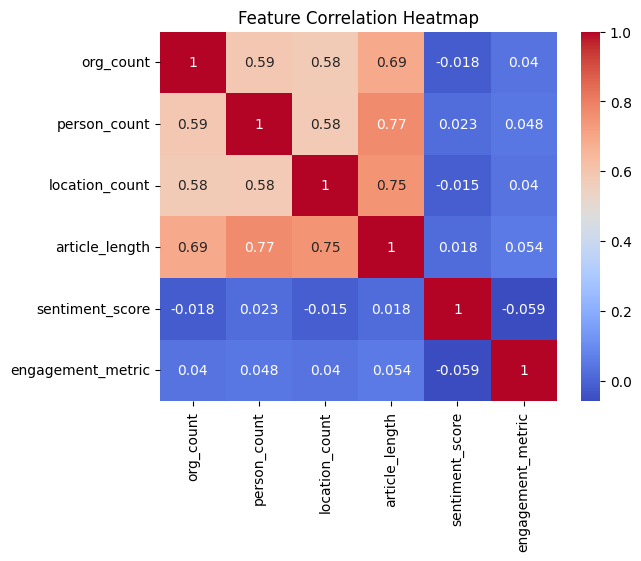

In [1]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


import nltk
nltk.download('punkt')
nltk.download('stopwords')


df = pd.read_csv("news.csv")  


print(df.head())
print(df.info())
print(df.isnull().sum())


df = df.dropna()


def preprocess_text(text):
    
    text = BeautifulSoup(text, "html.parser").get_text()
    
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    text = text.lower()
    return text


df['cleaned_text'] = df['text'].apply(preprocess_text)


stop_words = set(stopwords.words('english'))

def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return filtered

df['tokens'] = df['cleaned_text'].apply(tokenize_and_filter)


nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [ent.label_ for ent in doc.ents]
    return entities


df['entities'] = df['cleaned_text'].apply(extract_entities)


def count_entity_types(entities):
    entity_counts = pd.Series(entities).value_counts().to_dict()
    return entity_counts

df['entity_counts'] = df['entities'].apply(count_entity_types)

def extract_entity_count(entity_counts, entity_type):
    return entity_counts.get(entity_type, 0)

df['org_count'] = df['entity_counts'].apply(lambda x: extract_entity_count(x, 'ORG'))
df['person_count'] = df['entity_counts'].apply(lambda x: extract_entity_count(x, 'PERSON'))
df['location_count'] = df['entity_counts'].apply(lambda x: extract_entity_count(x, 'GPE'))



df['article_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))


def sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment_score'] = df['cleaned_text'].apply(sentiment_score)


df['engagement_metric'] = np.random.randint(1, 100, df.shape[0])  


features = ['org_count', 'person_count', 'location_count', 'article_length', 'sentiment_score']
y_column = 'engagement_metric'  

X = df[features]
y = df[y_column]



if X.shape[0] > 1:
    
    test_size = 0.2 if X.shape[0] > 5 else 0.1  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    
    y_pred = model.predict(X_test)

    
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)

else:
    print("Insufficient samples for training the model. Please check the dataset.")



entity_freq = df[['org_count', 'person_count', 'location_count']].sum()
entity_freq.plot(kind='bar', title="Entity Frequency")
plt.show()


plt.scatter(df['sentiment_score'], df[y_column])
plt.title("Sentiment vs Engagement")
plt.xlabel("Sentiment Score")
plt.ylabel("Engagement Metric")
plt.show()


correlation = df[features + [y_column]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


df.to_csv("processed_news_data.csv", index=False)
